test_image1.png: [(921, 373, 26, 26, 'Ticked'), (1141, 814, 24, 24, 'Ticked'), (1285, 814, 24, 24, 'Ticked')]
test_image2.png: [(921, 373, 26, 26, 'Unticked'), (1141, 814, 24, 24, 'Ticked'), (1285, 814, 24, 24, 'Unticked')]
test_image3.png: [(146, 813, 25, 26, 'Ticked'), (352, 813, 25, 25, 'Ticked'), (615, 813, 25, 25, 'Ticked'), (905, 813, 25, 25, 'Ticked'), (1249, 813, 25, 25, 'Ticked')]


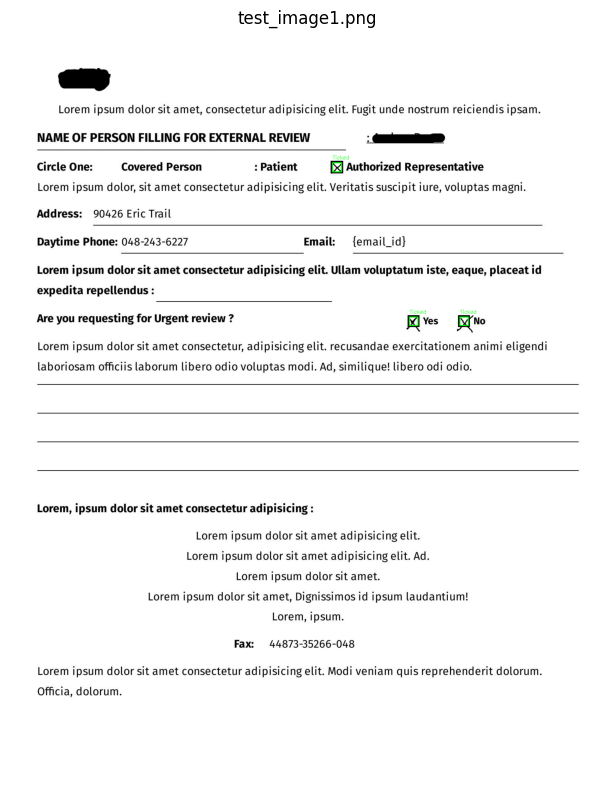

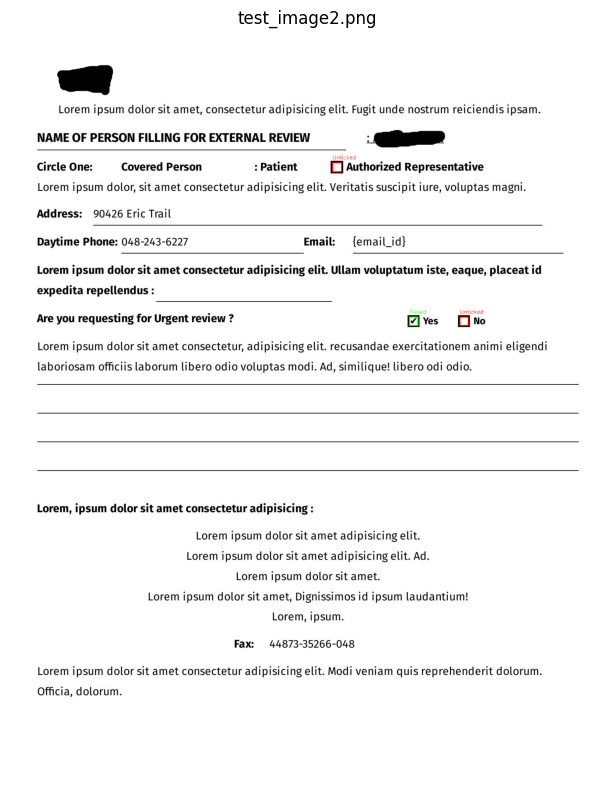

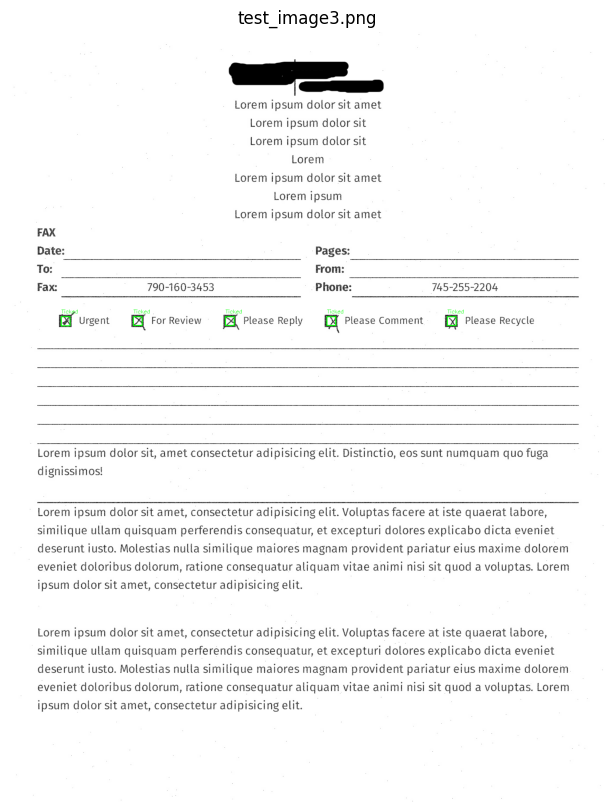

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_checkboxes(image, line_min_width = 15, line_max_width = 15):
    gray_scale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    th1, img_bin = cv2.threshold(gray_scale, 150, 255, cv2.THRESH_BINARY)
    img_bin = ~img_bin

    kernal_h_min = np.ones((1, line_min_width), np.uint8)
    kernal_v_min = np.ones((line_min_width, 1), np.uint8)
    kernal_h_max = np.ones((1, line_max_width), np.uint8)
    kernal_v_max = np.ones((line_max_width, 1), np.uint8)

    # Apply morphological operations
    img_bin_h_min = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_h_min)
    img_bin_v_min = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_v_min)
    img_bin_h_max = cv2.morphologyEx(img_bin, cv2.MORPH_CLOSE, kernal_h_max)
    img_bin_v_max = cv2.morphologyEx(img_bin, cv2.MORPH_CLOSE, kernal_v_max)

    # Combine the results
    img_bin_final = (img_bin_h_min & img_bin_h_max) | (img_bin_v_min & img_bin_v_max)
    
    final_kernel = np.ones((3, 3), np.uint8)
    img_bin_final = cv2.dilate(img_bin_final, final_kernel, iterations=1)
    
    # Find connected components
    _, labels, stats, _ = cv2.connectedComponentsWithStats(~img_bin_final, connectivity=8, ltype=cv2.CV_32S)

    return stats, labels

def classify_checkboxes(image, stats, min_width=10, max_width=50, tick_threshold=0.1):
    #kernel = np.ones((3, 3), np.uint8) 
    #image = cv2.erode(image, kernel)
    checkboxes = []
    for stat in stats[2:]:
        x, y, w, h, area = stat
        aspect_ratio = w / h
        if min_width <= w <= max_width and min_width <= h <= max_width and 0.8 <= aspect_ratio <= 1.2:
            roi = image[y:y+h, x:x+w]
            gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
            gray_roi = cv2.GaussianBlur(gray_roi, (5, 5), 0)
            binary_roi = cv2.adaptiveThreshold(gray_roi, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                               cv2.THRESH_BINARY_INV, 11, 2)
            kernel = np.ones((3, 3), np.uint8)
            binary_roi = cv2.morphologyEx(binary_roi, cv2.MORPH_OPEN, kernel)

            non_white_pixels = cv2.countNonZero(binary_roi)
            total_pixels = w * h
            tick_percentage = non_white_pixels / total_pixels

            if tick_percentage > tick_threshold:
                checkboxes.append((x, y, w, h, 'Ticked'))
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.putText(image, 'Ticked', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
            else:
                checkboxes.append((x, y, w, h, 'Unticked'))
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
                cv2.putText(image, 'Unticked', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    return checkboxes

def classify_checkboxes_in_folder(folder_path):
    results = {}
    images = {}
    for filename in os.listdir(folder_path):
        if filename.endswith((".png", ".jpg", ".jpeg", ".bmp")):  # add other image formats if needed
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)
            if image is not None:
                stats, labels = detect_checkboxes(image)
                checkboxes = classify_checkboxes(image, stats)
                results[filename] = checkboxes
                images[filename] = image
            else:
                print(f"Could not open or find the image: {filename}")
    return results, images

def plot_classified_images(images):
    for filename, image in images.items():
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(filename)
        plt.axis('off')
        plt.show()

folder_path = 'folder_path'
results, images = classify_checkboxes_in_folder(folder_path)

for filename, classification in results.items():
    print(f"{filename}: {classification}")

plot_classified_images(images)